In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm

In [7]:
# Load the MNIST dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [14]:
# Define the LeNet architecture
net = nn.Sequential(
    nn.Conv2d(1, 96, 11, 4), nn.ReLU(),
    nn.MaxPool2d(3, 2),
    nn.Conv2d(96, 256, 5, 1, 2), nn.ReLU(),
    nn.MaxPool2d(3, 2),
    nn.Conv2d(256, 384, 3, 1, 1), nn.ReLU(),
    nn.Conv2d(384, 384, 3, 1, 1), nn.ReLU(),
    nn.Conv2d(384, 256, 3, 1, 1), nn.ReLU(),
    nn.MaxPool2d(3, 2),
    nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Linear(4096, 10)

)


def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)


net.apply(init_weights)

Sequential(
  (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=6400, out_features=4096, bias=True)
  (15): ReLU()
  (16): Linear(in_features=4096, out_features=4096, bias=True)
  (17): ReLU()
  (18): Linear(in_features=4096, out_features=10, bias=True)
)

In [9]:
X = torch.rand(size=(1, 1, 224, 224), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 96, 54, 54])
ReLU output shape: 	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape: 	 torch.Size([1, 96, 26, 26])
Conv2d output shape: 	 torch.Size([1, 256, 26, 26])
ReLU output shape: 	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape: 	 torch.Size([1, 256, 12, 12])
Conv2d output shape: 	 torch.Size([1, 384, 12, 12])
ReLU output shape: 	 torch.Size([1, 384, 12, 12])
Conv2d output shape: 	 torch.Size([1, 384, 12, 12])
ReLU output shape: 	 torch.Size([1, 384, 12, 12])
Conv2d output shape: 	 torch.Size([1, 256, 12, 12])
ReLU output shape: 	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape: 	 torch.Size([1, 256, 5, 5])
Flatten output shape: 	 torch.Size([1, 6400])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Size([1, 4096])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Size([1, 4096])
Linear output shape: 	 torch.Size([1, 10])


In [15]:
train_dl = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dl = data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


In [17]:
n_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
net.train()

loss_hist = []

for epoch in range(n_epochs):
    pbar = tqdm(enumerate(train_dl), total=len(train_dl))
    for i, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            loss_hist.append(loss.item())
            pbar.set_description(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}')

Epoch 10/10, Loss: 0.0889: 100%|██████████| 938/938 [00:36<00:00, 25.75it/s]


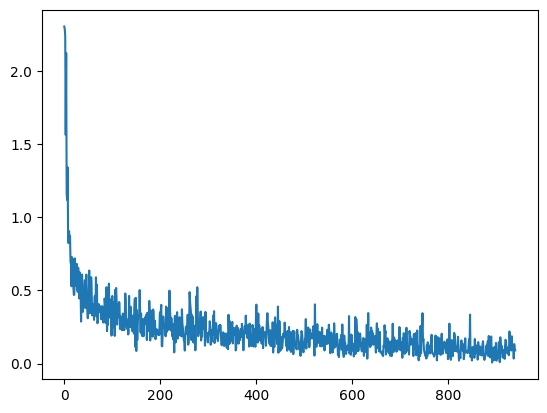

In [18]:
plt.plot(loss_hist)

In [21]:
import numpy as np

test_loss = []
net.eval()

for inputs, targets in test_dl:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())

print(np.mean(test_loss))

0.2635791953653097


In [22]:
# Evaluate the model
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')


Accuracy of the network on the 10000 test images: 91.93%
